In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from transformers import AdamW
import pandas as pd
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import csv
import re
import validators
import emoji
import unidecode
import nltk
import pickle
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the seed for reproducibility
SEED = 1237
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# BERT Hyperparameters (ADDITION)
n_bert_layers = 16  # Assuming the base model has 12 layers
bert_lr = 0.001
pooling_strategy = 'cls'  # Options: 'cls', 'mean', 'max'
bert_hidden_size = 768  # Adjust based on your BERT model
max_seq_length = 128
fine_tune_strategy = 'full'  # Options: 'full', 'last_layer'
bert_dropout = 0.9  # Adjust based on BERT model specifications

max_seq_length = 128  # This should match the max_seq_length used in BERT model
padding_strategy = 'max_length'  # Options: 'max_length', 'do_not_pad', 'longest'
truncation_strategy = 'longest_first'  # Options: 'longest_first', 'only_first', 'only_second'
do_lower_case = False  # Set to False if using a cased model

config = BertConfig(
    num_hidden_layers=n_bert_layers,
    hidden_size=bert_hidden_size,
    num_attention_heads=24,  # Assuming 12 attention heads
    intermediate_size=4 * bert_hidden_size,  # Default value in BERT
    hidden_dropout_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', 
                                          max_length=max_seq_length,
                                          padding=padding_strategy,
                                          truncation=truncation_strategy,
                                          do_lower_case=do_lower_case)
# Load the BERT model with the custom configuration
bert_model = BertModel(config=config)

In [3]:
data_path = "multilabel-dataset.csv"  
data_df = pd.read_csv(data_path)
data_df = data_df.rename(columns={'Tweet Content': 'text', 'Sentiment': 'sentiment', 'Label': 'label'})

In [4]:
data_df

,text,sentiment,label
0,Dictator's son on the cusp of power in the #Ph...,Negative,Hate
1,Kung ang definition ni BongBong Marcos sa isan...,Negative,Hate
2,Leni Robredo is not being subjected by her opp...,Negative,Hate
3,@imstillsour Tuwang tuwa sila sa Pink hahaha.....,Negative,Hate
4,Kapag hindi si VP Leni Robredo ang iboboto mo ...,Negative,Hate
...,...,...,...
7675,VP LENI ROBREDO FOR 2022 https://t.co/2ahSefgmST,Neutral,Non-hate
7676,@alt_ego143 @rapplerdotcom @ramboreports hindi...,Neutral,Non-hate
7677,"I can't vote yet, but my president is Leni Rob...",Neutral,Non-hate
7678,Anyways President Leni Robredo #SaveLegendsOfT...,Neutral,Non-hate


In [5]:
# Preprocessing function
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:tokenizer.model_max_length - 2]  # Account for [CLS] and [SEP] tokens
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    return indexed_tokens

filipino_stopwords = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

# Date De-Identification
def remove_mentions(text):
    mention_pattern = re.compile(r'@\w+')
    
    # Use re.sub to remove mentions
    cleaned_text = mention_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# URL Removal
def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Use re.sub to remove URLs
    cleaned_text = url_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# Special Characters Removal
def remove_special_characters(text):
    text = emoji.replace_emoji(text, replace="[emoji]")
    
    # Split the text into words
    words = text.split(" ")
    
    # Initialize an empty string to store the cleaned text
    cleaned_text = ""
    
    # Iterate through each word
    for word in words:
        # Check if the word contains only special characters or "[emoji]"
        if not (re.match(r"^[_\W]+$", word) or "[emoji]" in word):
            if len(cleaned_text) == 0:
                cleaned_text = f"{word}"
            else:
                cleaned_text = f"{cleaned_text} {word}"
                
    # Remove diacritics
    text_no_diacritics = unidecode.unidecode(cleaned_text)

    # Split the text into words
    sentence = text_no_diacritics.split(" ")
    output = ""

    # Remove special characters and numerics
    for part in sentence:
        part = re.sub("[^A-Za-z ]+$", "", part)
        part = re.sub("^[^A-Za-z #]+", "", part)
        if not (len(part) <= 1 or re.match(r"[^a-zA-Z#]", part)):
            if len(output) == 0:
                output = f"{part}"
            else:
                output = f"{output} {part}"

    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(output.split())

    return cleaned_text

# Remove English Stop Words
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

# Remove English Stop Words
def remove_english_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text

# Remove Filipino Stop Words
def remove_filipino_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in filipino_stopwords]
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(filtered_words)
  
    return cleaned_text

# Candidate Name Removal
def remove_candidate_names(text):
    candidatelist = "leni robredo bongbong marcos isko moreno domagoso manny pacman pacquiao ping lacson ernie abella leody de guzman norberto gonzales jose montemayor jr faisal mangondato"
    candidatelist = candidatelist.split()
    candidate_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, candidatelist)) + r')\b', re.IGNORECASE)
    
    # Use re.sub to remove candidate names
    cleaned_text = candidate_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())
        
    return cleaned_text

# Hashtag Removal
def remove_hashtags(text):
    # Split the text into words
    words = text.split()
    
    # Initialize an empty list to store cleaned words
    cleaned_words = []
    
    for word in words:
        # Check if the word is a hashtag (starts with #)
        if not word.startswith('#'):
            cleaned_words.append(word)
    
    # Join the cleaned words into a single string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

In [6]:
# Lowercase except All Capital Words
def lowercase_except_all_caps(text):
    cleaned_text = remove_special_characters(text)
    
    words = cleaned_text.split()
    filtered_words = []
    
    for word in words:
        if word.isupper() and not word.istitle():
            filtered_words.append(word)
        else:
            filtered_words.append(re.sub(r'([A-Z][a-z]+)', lambda x: x.group(1).lower(), word))
            
    return ' '.join(filtered_words)

In [7]:
for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos
https://t.co/5wbFYVWlG4 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista.

EJK sa Drug War at Martial Law mismo ang ebidensya.

#ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... https://t.co/hzn3LiQ5uJ 

Sentiment:  Negative 

-------------------------------------------------

Text:  @imstillsour Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila l

In [8]:
#PreProcessing

In [9]:
# Data De-Identification
data_df['text'] = data_df['text'].apply(remove_mentions)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos https://t.co/5wbFYVWlG4 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista. EJK sa Drug War at Martial Law mismo ang ebidensya. #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... https://t.co/hzn3LiQ5uJ 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink 

In [10]:
# URL Removal
data_df['text'] = data_df['text'].apply(remove_url)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista. EJK sa Drug War at Martial Law mismo ang ebidensya. #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink hahaha😅😂😂 

Sentiment:  Negative 

-------------

In [11]:
# Special Characters Removal
data_df['text'] = data_df['text'].apply(remove_special_characters)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit nanunupil ng civilian teenager na NON COMBATANT pinapatunayan lang na ang PNP-AFP ay terorista EJK sa Drug War at Martial Law mismo ang ebidensya #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question we do not want puppet president 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink 

Sentiment:  Negative 

-------------------------------------

In [12]:
# Lowercase
data_df['text'] = data_df['text'].apply(lowercase_except_all_caps)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  dictator's son on the cusp of power in the #philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  kung ang definition ni bongbong marcos sa isang terorista ay isang armadong grupo na nananakit nanunupil ng civilian teenager na NON COMBATANT pinapatunayan lang na ang PNP-AFP ay terorista EJK sa drug war at martial law mismo ang ebidensya #manggagawaVSmagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  leni robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question we do not want puppet president 

Sentiment:  Negative 

-------------------------------------------------

Text:  tuwang tuwa sila sa pink hahaha..hindi nila alam pink color is sign for bongbong marcos..kasi favorite nya isuot pink...ambilis ni leni mag grab ng color kasi nakita nila langit nag pink 

Sentiment:  Negative 

-------------------------------------

In [13]:
# Remove Hashtags
data_df['text'] = data_df['text'].apply(remove_hashtags)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  dictator's son on the cusp of power in the 

Sentiment:  Negative 

-------------------------------------------------

Text:  kung ang definition ni bongbong marcos sa isang terorista ay isang armadong grupo na nananakit nanunupil ng civilian teenager na NON COMBATANT pinapatunayan lang na ang PNP-AFP ay terorista EJK sa drug war at martial law mismo ang ebidensya 

Sentiment:  Negative 

-------------------------------------------------

Text:  leni robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question we do not want puppet president 

Sentiment:  Negative 

-------------------------------------------------

Text:  tuwang tuwa sila sa pink hahaha..hindi nila alam pink color is sign for bongbong marcos..kasi favorite nya isuot pink...ambilis ni leni mag grab ng color kasi nakita nila langit nag pink 

Sentiment:  Negative 

-------------------------------------------------

Text:  kapag hindi si VP leni r

In [14]:
data_df.to_csv('pmulti-AC7030.csv', index=False)

In [15]:
data_df

,text,sentiment,label
0,dictator's son on the cusp of power in the,Negative,Hate
1,kung ang definition ni bongbong marcos sa isan...,Negative,Hate
2,leni robredo is not being subjected by her opp...,Negative,Hate
3,tuwang tuwa sila sa pink hahaha..hindi nila al...,Negative,Hate
4,kapag hindi si VP leni robredo ang iboboto mo ...,Negative,Hate
...,...,...,...
7675,VP LENI ROBREDO FOR,Neutral,Non-hate
7676,hindi pangngumbinse ang tawag dyan what he is ...,Neutral,Non-hate
7677,can't vote yet but my president is leni robred...,Neutral,Non-hate
7678,anyways president leni robredo,Neutral,Non-hate


In [16]:
data_df['text'] = data_df['text'].apply(preprocess_text)

In [17]:
data_df.to_csv('pmulti-tokenized-AC7030.csv', index=False)

In [18]:
data_df

,text,sentiment,label
0,"[26400, 112, 188, 1488, 1113, 1103, 16408, 200...",Negative,Hate
1,"[180, 4380, 1126, 1403, 5754, 11437, 171, 4553...",Negative,Hate
2,"[5837, 2605, 187, 12809, 20792, 1110, 1136, 12...",Negative,Hate
3,"[189, 1358, 15946, 189, 1358, 3624, 27466, 174...",Negative,Hate
4,"[24181, 4163, 1403, 24856, 1182, 27466, 23659,...",Negative,Hate
...,...,...,...
7675,"[23659, 149, 11680, 2240, 155, 2346, 26166, 10...",Neutral,Non-hate
7676,"[24856, 1182, 13316, 17653, 19524, 7939, 2217,...",Neutral,Non-hate
7677,"[1169, 112, 189, 2992, 1870, 1133, 1139, 2084,...",Neutral,Non-hate
7678,"[4050, 1116, 2084, 5837, 2605, 187, 12809, 20792]",Neutral,Non-hate


In [19]:
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=SEED)

In [20]:
### changed output_dim=3, added torch.softmax

In [21]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout) 
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=2, padding='same')
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=4, padding='same')
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        x = embedded.permute(0, 2, 1)  # Change the dimensions for convolution
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.global_pooling(x).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [22]:
# Set up iterators
BATCH_SIZE = 64

In [23]:
### changed "label" to "sentiment"

In [24]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_seq_length):
        self.data = dataframe
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']

        # Padding and conversion to tensor
        padded_text = torch.tensor(text[:self.max_seq_length] + [0] * (self.max_seq_length - len(text)))
        return padded_text, sentiment

In [25]:
train_dataset = TextDataset(train_df, 1000)
test_dataset = TextDataset(test_df, 1000)

In [26]:
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
# Define model hyperparameters
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 768
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 3
DROPOUT = 0.5

# CNN Hyperparameters
hidden_dim = 100
n_conv_layers = 1
kernel_sizes = [2, 3, 4]
activation = nn.ReLU()

In [28]:
# Initialize CNN model
model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [29]:
# Initialize BERT model (for embedding extraction)
bert_model.eval()  # Set to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.9, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-15): 16 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.9, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.9, inplace=False)
  

In [30]:
with torch.no_grad():
    for i, token in enumerate(tokenizer.get_vocab()):
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_embedding = bert_model.embeddings.word_embeddings.weight[token_id]
        model.embedding.weight[i].data.copy_(token_embedding)

bert_parameters = []
for layer in bert_model.encoder.layer:
    bert_parameters.extend(layer.parameters())

# Create AdamW optimizer with custom hyperparameters for BERT embeddings
bert_learning_rate = 2e-4  # Adjust as needed
bert_optimizer = optim.AdamW(bert_parameters, lr=bert_learning_rate)

In [31]:
#optimizer = optim.Adam(model.parameters())
# Your custom hyperparameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
weight_decay = 0.0

# Create Adam optimizer with custom hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [32]:
# Create a dictionary to map class labels to numerical indices
label_to_index = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

# Train function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, iterator):
    model.train()
    epoch_loss = 0
    for text_batch, sentiment_batch in iterator:
        # Extract text sequences from the text_batch tensor
        texts = text_batch
        
        # Use numerical labels for multi-class classification
        labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)

        texts = texts.to(device)  # Move to device if needed
        
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Evaluate function
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    predicted_sentiments = []
    true_sentiments = []  # Declare the true_sentiments list
    
    with torch.no_grad():
        for text_batch, sentiment_batch in iterator:
            texts = text_batch  # Extract text sequences
            
            # Use numerical labels
            labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)
            
            texts = texts.to(device)  # Move to device
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            # Convert predictions to class labels
            predicted_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in torch.argmax(predictions, dim=1).cpu().numpy()])
            true_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in labels.cpu().numpy()])
    
    # Calculate accuracy, f1, precision, recall
    accuracy = accuracy_score(true_sentiments, predicted_sentiments)
    f1 = f1_score(true_sentiments, predicted_sentiments, average='macro')
    precision = precision_score(true_sentiments, predicted_sentiments, average='macro')
    recall = recall_score(true_sentiments, predicted_sentiments, average='macro')
    
    return epoch_loss / len(iterator), accuracy, f1, precision, recall, predicted_sentiments, true_sentiments

D:\Users\Mai\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 01

	Train Loss: 1.041
	Test Loss: 0.971

	Accuracy: 0.5503 | F1-Score: 0.4446
	Precision: 0.6165 | Recall: 0.5513

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.5857    0.8590    0.6965       780
    Negative     0.7500    0.0078    0.0154       772
     Neutral     0.5139    0.7872    0.6218       752

    accuracy                         0.5503      2304
   macro avg     0.6165    0.5513    0.4446      2304
weighted avg     0.6173    0.5503    0.4439      2304


[[670   1 109]
 [315   6 451]
 [159   1 592]]


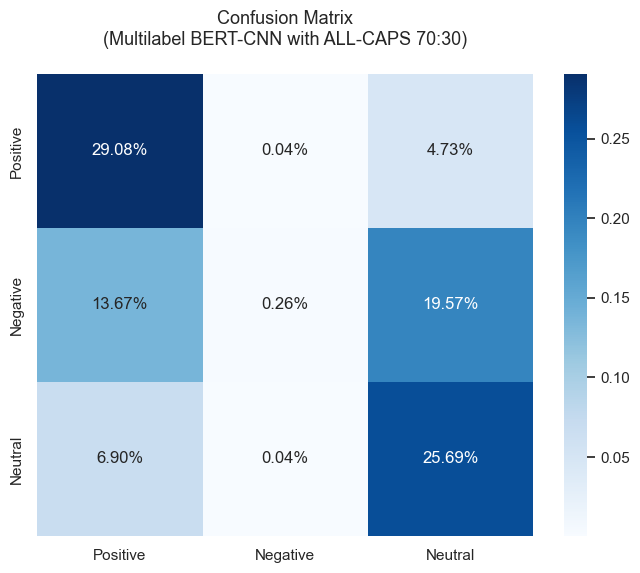

Epoch: 02

	Train Loss: 0.953
	Test Loss: 0.956

	Accuracy: 0.5638 | F1-Score: 0.5454
	Precision: 0.5433 | Recall: 0.5644

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6438    0.7205    0.6800       780
    Negative     0.4208    0.2720    0.3304       772
     Neutral     0.5655    0.7008    0.6259       752

    accuracy                         0.5638      2304
   macro avg     0.5433    0.5644    0.5454      2304
weighted avg     0.5435    0.5638    0.5452      2304


[[562 151  67]
 [224 210 338]
 [ 87 138 527]]


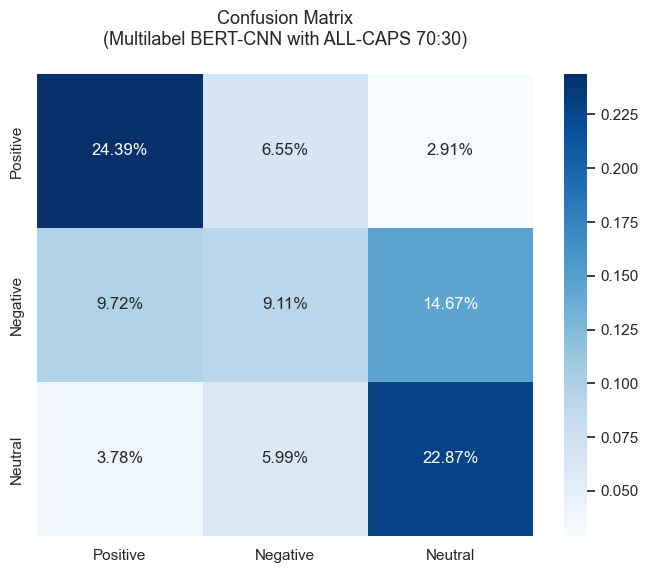

Epoch: 03

	Train Loss: 0.903
	Test Loss: 0.923

	Accuracy: 0.6094 | F1-Score: 0.6085
	Precision: 0.6080 | Recall: 0.6090

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7024    0.7231    0.7126       780
    Negative     0.4935    0.4883    0.4909       772
     Neutral     0.6282    0.6157    0.6219       752

    accuracy                         0.6094      2304
   macro avg     0.6080    0.6090    0.6085      2304
weighted avg     0.6082    0.6094    0.6087      2304


[[564 169  47]
 [168 377 227]
 [ 71 218 463]]


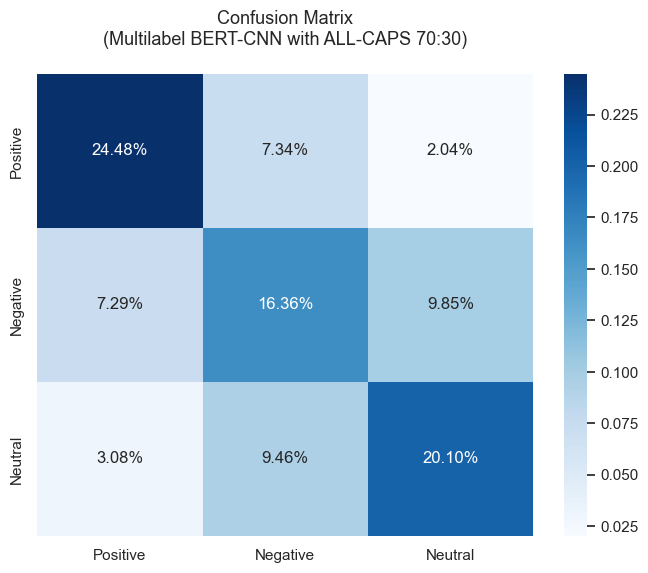

Epoch: 04

	Train Loss: 0.856
	Test Loss: 0.922

	Accuracy: 0.6072 | F1-Score: 0.6008
	Precision: 0.5998 | Recall: 0.6075

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6985    0.7218    0.7100       780
    Negative     0.5040    0.4093    0.4518       772
     Neutral     0.5970    0.6915    0.6408       752

    accuracy                         0.6072      2304
   macro avg     0.5998    0.6075    0.6008      2304
weighted avg     0.6002    0.6072    0.6009      2304


[[563 158  59]
 [164 316 292]
 [ 79 153 520]]


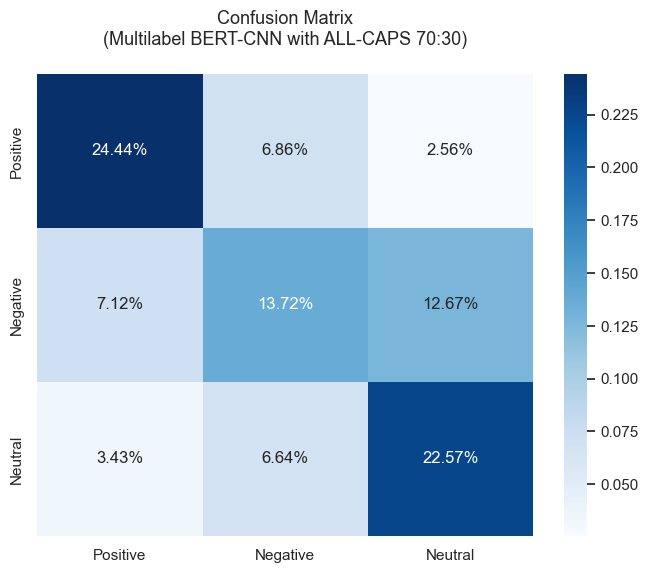

Epoch: 05

	Train Loss: 0.816
	Test Loss: 0.909

	Accuracy: 0.6276 | F1-Score: 0.6269
	Precision: 0.6267 | Recall: 0.6272

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7095    0.7295    0.7193       780
    Negative     0.5318    0.5311    0.5314       772
     Neutral     0.6389    0.6210    0.6298       752

    accuracy                         0.6276      2304
   macro avg     0.6267    0.6272    0.6269      2304
weighted avg     0.6269    0.6276    0.6272      2304


[[569 150  61]
 [159 410 203]
 [ 74 211 467]]


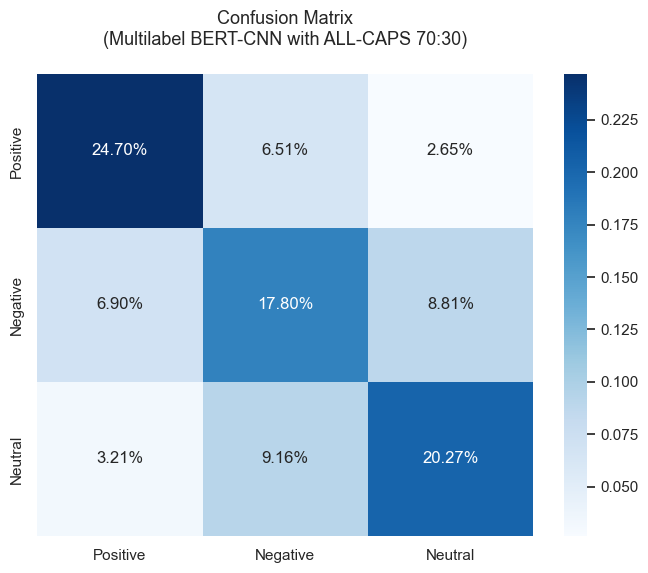

Epoch: 06

	Train Loss: 0.779
	Test Loss: 0.912

	Accuracy: 0.6224 | F1-Score: 0.6219
	Precision: 0.6218 | Recall: 0.6221

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7130    0.7231    0.7180       780
    Negative     0.5162    0.5155    0.5159       772
     Neutral     0.6361    0.6277    0.6319       752

    accuracy                         0.6224      2304
   macro avg     0.6218    0.6221    0.6219      2304
weighted avg     0.6220    0.6224    0.6222      2304


[[564 168  48]
 [152 398 222]
 [ 75 205 472]]


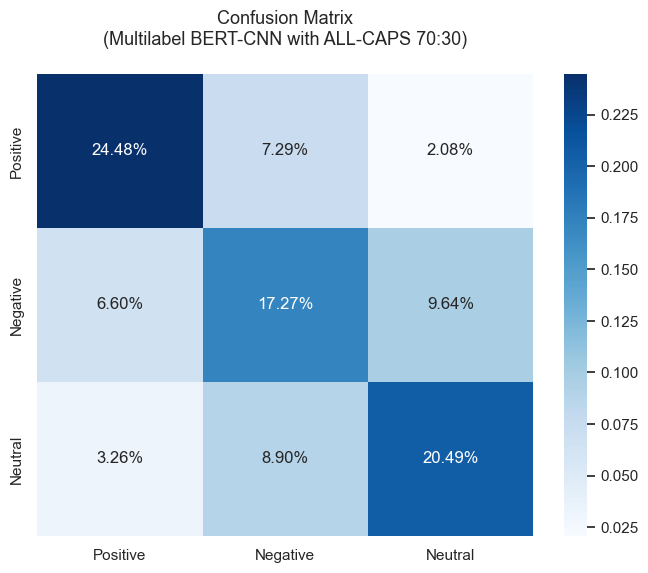

Epoch: 07

	Train Loss: 0.759
	Test Loss: 0.915

	Accuracy: 0.6259 | F1-Score: 0.6244
	Precision: 0.6331 | Recall: 0.6245

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7066    0.7564    0.7307       780
    Negative     0.5175    0.5946    0.5533       772
     Neutral     0.6753    0.5226    0.5892       752

    accuracy                         0.6259      2304
   macro avg     0.6331    0.6245    0.6244      2304
weighted avg     0.6330    0.6259    0.6251      2304


[[590 153  37]
 [161 459 152]
 [ 84 275 393]]


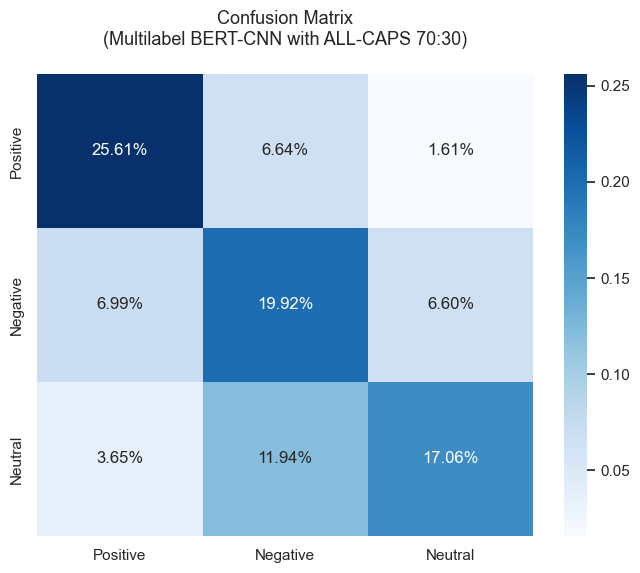

Epoch: 08

	Train Loss: 0.744
	Test Loss: 0.916

	Accuracy: 0.6202 | F1-Score: 0.6179
	Precision: 0.6176 | Recall: 0.6196

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6942    0.7538    0.7228       780
    Negative     0.5193    0.5065    0.5128       772
     Neutral     0.6392    0.5984    0.6181       752

    accuracy                         0.6202      2304
   macro avg     0.6176    0.6196    0.6179      2304
weighted avg     0.6176    0.6202    0.6183      2304


[[588 142  50]
 [177 391 204]
 [ 82 220 450]]


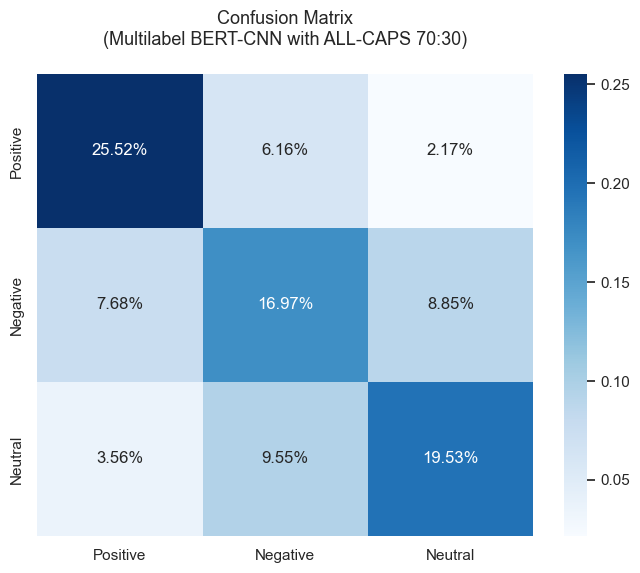

Epoch: 09

	Train Loss: 0.740
	Test Loss: 0.914

	Accuracy: 0.6224 | F1-Score: 0.6183
	Precision: 0.6243 | Recall: 0.6210

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6732    0.7872    0.7258       780
    Negative     0.5269    0.5453    0.5360       772
     Neutral     0.6728    0.5306    0.5933       752

    accuracy                         0.6224      2304
   macro avg     0.6243    0.6210    0.6183      2304
weighted avg     0.6241    0.6224    0.6189      2304


[[614 127  39]
 [196 421 155]
 [102 251 399]]


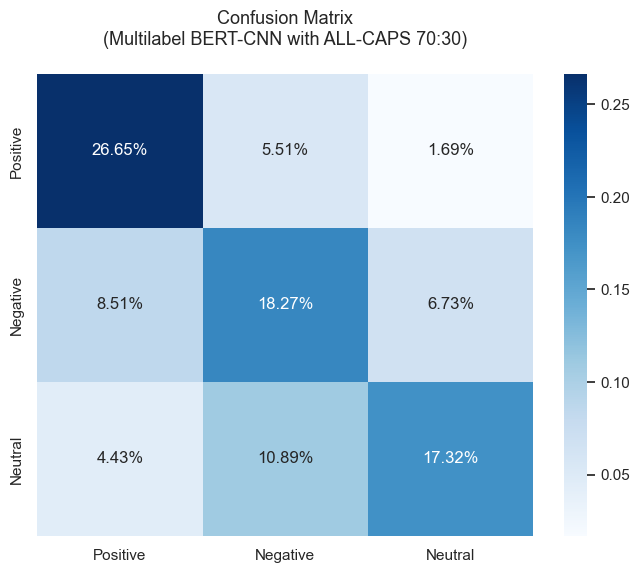

Epoch: 10

	Train Loss: 0.721
	Test Loss: 0.914

	Accuracy: 0.6228 | F1-Score: 0.6213
	Precision: 0.6229 | Recall: 0.6220

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6944    0.7487    0.7205       780
    Negative     0.5257    0.5427    0.5341       772
     Neutral     0.6486    0.5745    0.6093       752

    accuracy                         0.6228      2304
   macro avg     0.6229    0.6220    0.6213      2304
weighted avg     0.6230    0.6228    0.6218      2304


[[584 142  54]
 [173 419 180]
 [ 84 236 432]]


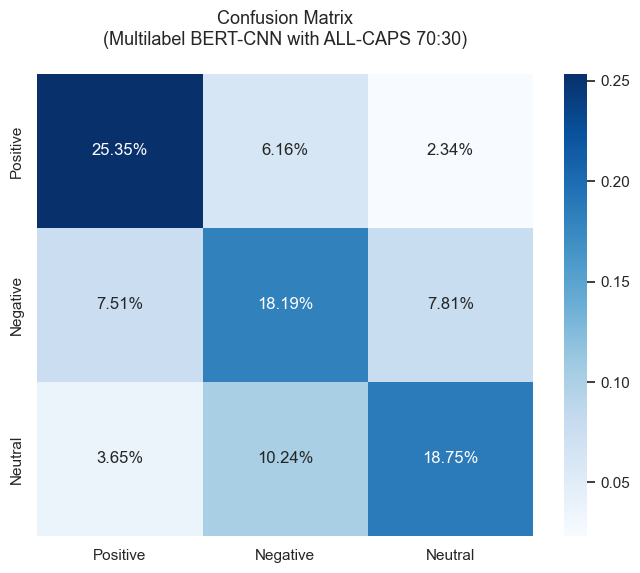

In [33]:
from sklearn.metrics import classification_report

N_EPOCHS = 10
predicted_sentiments_per_epoch = []
true_sentiments_per_epoch = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator)
    test_loss, accuracy, f1, precision, recall, predicted_sentiments, true_sentiments = evaluate(model, test_iterator)
    
    # Save the predicted_sentiments and true_sentiments for the current epoch
    predicted_sentiments_per_epoch.append(predicted_sentiments)
    true_sentiments_per_epoch.append(true_sentiments)

    # Print other metrics (e.g., accuracy, loss) for the current epoch
    print(f'Epoch: {epoch + 1:02}\n')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest Loss: {test_loss:.3f}\n')
    print(f'\tAccuracy: {accuracy:.4f} | F1-Score: {f1:.4f}')
    print(f'\tPrecision: {precision:.4f} | Recall: {recall:.4f}\n')
    print(f'\tClassification Report:\n')
    report = classification_report(true_sentiments, predicted_sentiments, target_names=['Positive', 'Negative', 'Neutral'], digits = 4)
    print(f'{report}\n')
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np  # Import numpy for matrix normalization

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(true_sentiments, predicted_sentiments)
    print(cf_matrix)

    # Plot the confusion matrix using seaborn
    sns.set(rc={"figure.figsize": (8, 6)})  # Add a closing parenthesis to set
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'], fmt='.2%', cmap='Blues')

    plt.title('Confusion Matrix\n(Multilabel BERT-CNN with ALL-CAPS 70:30)\n', fontsize=13)
    plt.show()